In [1]:
import pandas as pd
import requests
import json
import numpy as np
import dataretrieval as nwis
import geopandas
import geojson

In [4]:
states = geopandas.read_file("../data/mapping/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")
states = states.to_crs(epsg=4269)
st = ["Idaho",'Washington','Oregon']
states = states[states["NAME"].isin(st)]

In [5]:
df = geopandas.read_file("../data/FLOwPER_v2/FLOwPER_v2.shp")[['ESRIGNSS_L','ESRIGNSS_1']]

In [6]:
out = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.ESRIGNSS_1, df.ESRIGNSS_L), crs="EPSG:4326"
)
out = out.to_crs(epsg=4269)
FlowPER= geopandas.clip(out,states)

In [7]:
## Load streamflow catalog and drop OWRD

In [8]:
df = pd.read_excel("../data/Streamflow_Catalog_2023-02-06.xlsx")
df = df[df["long"]<0]

## Drop OWRD
df = df[df["organization"] != "Oregon Water Resources Department"]

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.long, df.lat), crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=4269)

## Filter for cont, USGS, and non-cont
cont = gdf[(gdf["meas.freq"] == "continuous") & (gdf.organization != "United States Geological Survey")]
cont_usgs = gdf[(gdf["meas.freq"] == "continuous") & (gdf.organization == "United States Geological Survey")]
non_cont = gdf[(gdf["meas.freq"] != "continuous")]

cont = geopandas.clip(cont,states)
cont_usgs = geopandas.clip(cont_usgs,states)
non_cont = geopandas.clip(non_cont,states)

In [9]:
## Load OWRD from Stephen

In [10]:
owrd = pd.read_excel("../data/OWRD_Gaging_station_List.xlsx")

gdf = geopandas.GeoDataFrame(
    owrd, geometry=geopandas.points_from_xy(owrd["longitude_dec"], owrd["latitude_dec"]), crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=4269)

owrd_cont = gdf[gdf.current_operation_ == "YR"]
owrd_non = gdf[gdf.current_operation_ != "YR"]

owrd_cont = geopandas.clip(owrd_cont,states)
owrd_non = geopandas.clip(owrd_non,states)

In [11]:
## Plot all continuous measurements

In [35]:
pnw_hydro = geopandas.read_file("../data/mapping/pnw_hydrologic_landscape_class/PNW Hydrologic Landscape Class.shp")
pnw_hydro_repro = pnw_hydro.to_crs(epsg=4269)
pnw_hydro_repro.CLASS = pnw_hydro['CLASS'].astype(str).str[0:1]

pal = {'V': '#728C48',
       'W': '#96B06A',
       'M': '#C6BD6C',
       'D': '#FFCD93',
       'S': '#EC975F' ,
       'A': '#B0632F',
        'B': "#000000"}

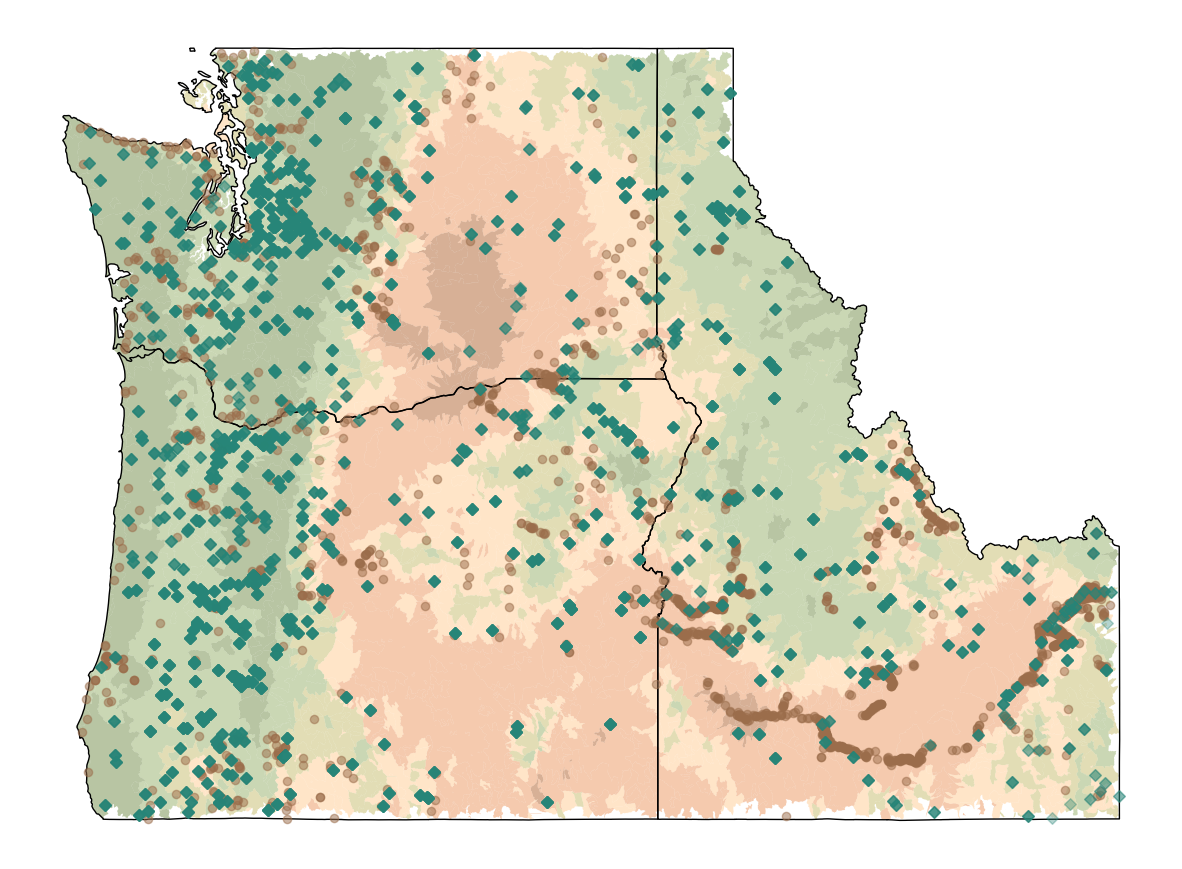

In [51]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['path.simplify'] = True
f,ax = plt.subplots(figsize=(15, 15))

pnw_hydro_repro.plot(ax=ax,legend=True,color = pnw_hydro_repro['CLASS'].map(pal),alpha= .5,edgecolor="none")
states.plot(ax=ax,facecolor="none",edgecolor = "black")
cont.plot(ax=ax,markersize = 35,alpha = 0.5,color = "#9B6D4B")
owrd_cont.plot(ax=ax,markersize = 35,alpha = 0.5,color = "#9B6D4B")
cont_usgs.plot(ax=ax,markersize = 35,alpha = 0.35,color = "#278578",marker = "D")

ax.set_axis_off();
plt.savefig("../docs/PNW_ContGages.png",dpi=600,transparent=True)

In [13]:
## Plot all descrete or not active measurements

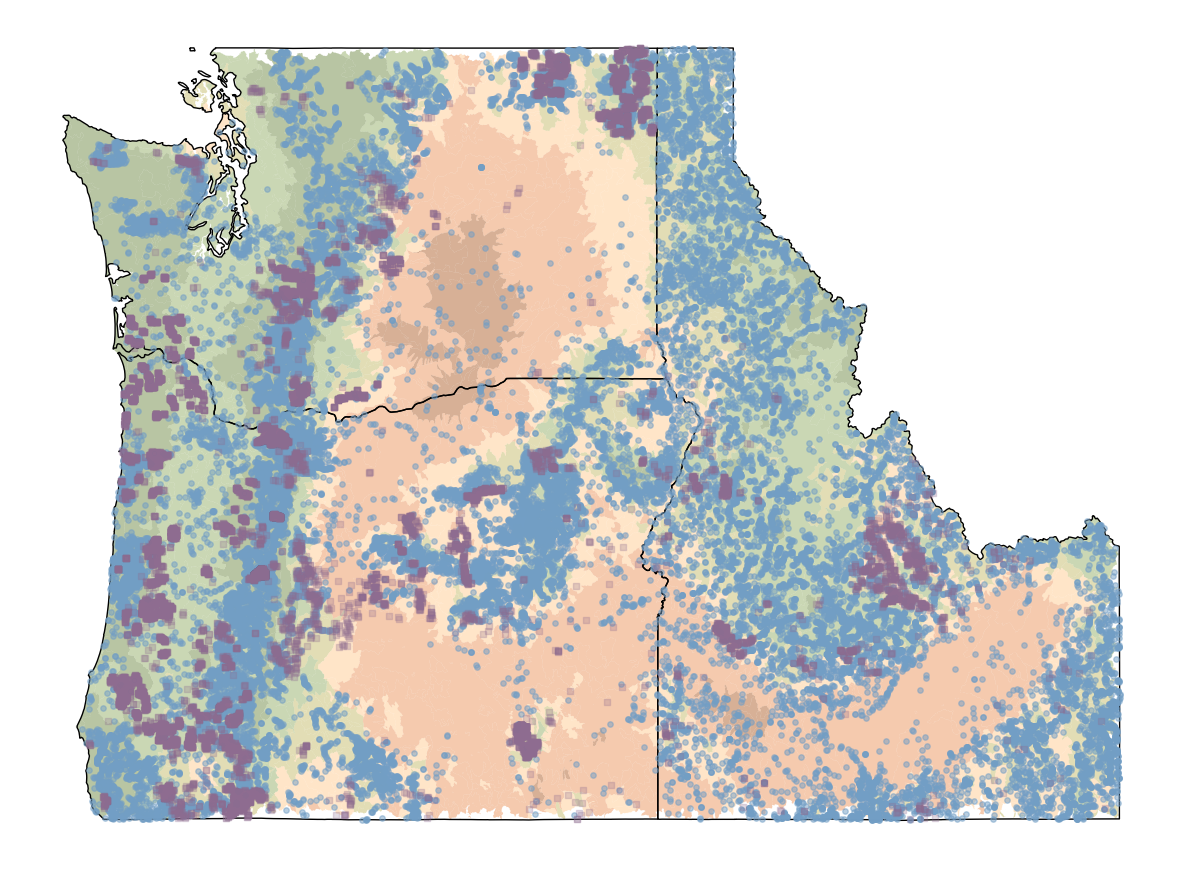

In [52]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(15, 15))

pnw_hydro_repro.plot(ax=ax,legend=True,color = pnw_hydro_repro['CLASS'].map(pal),alpha= .5,edgecolor="none")
states.plot(ax=ax,facecolor="none",edgecolor = "black")
non_cont.plot(ax=ax,markersize = 15,alpha = 0.5,color = "#729EC5")
owrd_non.plot(ax=ax,markersize = 15,alpha = 0.5,color = "#729EC5")
FlowPER.plot(ax=ax,markersize = 25,alpha = 0.25,color = "#8E6C90",marker = "s")

ax.set_axis_off();
plt.savefig("../docs/PNW_DesMeas.png",dpi=600,transparent=True)